# Assignment 3
Prepared by Talha Alvi and Farhan Wadia

## Exercise 1 (Programming Exercise)

Refer to a description of the shared autonomous vehicle (SAV) problem [here](https://smartmobilityalgorithms.github.io/book/content/PeopleMobilityProblems/carsharing/CarSharing.html). The purpose of this notebook is to extend on this work by implementing the problem for 3 vehicles instead of 1 or 2, and by developing an adaptive genetic algorithm, particle swarm optimization, and adaptive particle swarm optimization as alternative methods for solving the problem. 

### Data

In [38]:
import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest
import matplotlib.pyplot as plt

depots = pd.read_csv("./carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("./carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("./carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

# Import a pre-calculated trip distance matrix
# These distances are based off of an osrm routing
tm = pd.read_csv("./trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Genetic Algorithm with 3 Vehicles

#### Solution Class

In [2]:
class GACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            #print("Iter: ")
            #print(x)
            #print(" ")
            #print(self.costs)
            self.states.append(max(self.costs))
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                sig = 1 - 0.9*(x/self.iterations)
                if random.random() < sig:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        # print("States:", self.states)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

In [3]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

In [4]:
solver = GACarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes, 
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
solver.initial_population()
solver.run()

Initial Population costs:
[3973.91, -114.97, 13123.01, 14206.64, 7153.58, 11412.86, 8846.42, -883.33, 4720.01, 1940.69, 1418.42, -59.2, 1340.42, 6046.1, 3627.17, 5919.35]
Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: Loblaws ID: 31582988]
Best Solution Profits: 18300.59


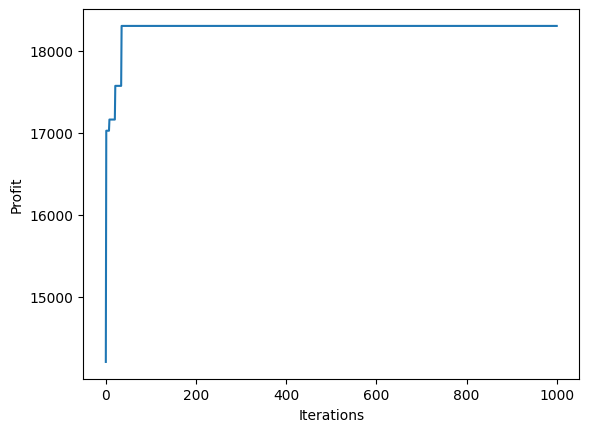

In [5]:
solver.visualize_graph()

In [6]:
solver.visualize_solution()

#### 3 Vehicle Solution

Partition the pickup nodes into 3 clusters for the 3 vehicles, and visualize them on the map.

In [7]:
from folium import Map, Marker, PolyLine, Icon
m = Map(location=pickup_nodes[0].coordinates[::-1], zoom_start=11)
bathurst_start = [43.82720773214452, -79.45379689449601]
bathurst_end = [43.636628218276, -79.3998242335392]
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
for x in pickup_nodes:
    if pickup_nodes.index(x) in second_vehicle_index:
        c  = "green"
    if pickup_nodes.index(x) in first_vehicle_index:
        c = "purple"
    if pickup_nodes.index(x) in third_vehicle_index:
        c = "red"
    Marker(location=x.coordinates[::-1], popup=x.coordinates, icon=Icon(color=c)).add_to(m)
PolyLine([bathurst_start, bathurst_end], color="red").add_to(m)
m

In [8]:
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
first_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in first_vehicle_index]
first_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in first_vehicle_index]
second_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in second_vehicle_index]
second_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in second_vehicle_index]
third_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in third_vehicle_index]
third_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in third_vehicle_index]

In [9]:
first_solver = GACarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
first_solver.initial_population()
first_solver.run()

Initial Population costs:
[-2221.01, -225.71, -2148.8, -2633.03, -225.71, 2316.34, 1849.72, 1361.68, -225.71, 2501.26, 2501.26, -2633.03, 1758.19, -1405.73, 2980.12, -530.36]
Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: 527 ID: 401220437]
Best Solution Profits: 3237.25


In [10]:
second_solver = GACarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0]],
    post_avoid = [first_solver.solution[-1]])

# Initialize the population
second_solver.initial_population()
second_solver.run()

Initial Population costs:
[3839.54, 4127.15, 2598.65, 3839.54, 4127.15, 1159.43, 3030.77, 1159.43, 3839.54, 2598.65, 1159.43, 4127.15, 3030.77, 4127.15, 1159.43, 2598.65]
Best Solution: [Name: 93 ID: 4035051033, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 75 ID: 31812627]
Best Solution Profits: 4127.15


In [11]:
third_solver = GACarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], second_solver.solution[0]],
    post_avoid = [first_solver.solution[-1], second_solver.solution[-1]])

# Initialize the population
third_solver.initial_population()
third_solver.run()

Initial Population costs:
[5088.95, 5533.52, 6442.67, 5088.95, 6442.67, 5088.95, 2417.66, 5088.95, 2417.66, 6442.67, 5533.52, 6442.67, 6442.67, 5533.52, 5088.95, 4724.06]
Best Solution: [Name: 39 ID: 4948854636, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: Loblaws ID: 31582988]
Best Solution Profits: 6442.67


In [12]:
print("Total profit:",round(first_solver.solution_cost + 
                            second_solver.solution_cost + 
                            third_solver.solution_cost,2))

Total profit: 13807.07


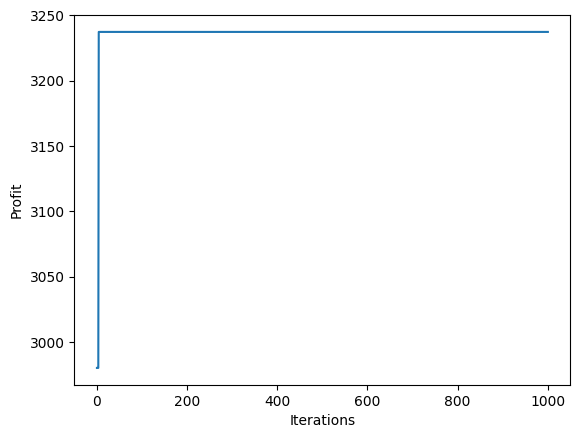

In [13]:
first_solver.visualize_graph()

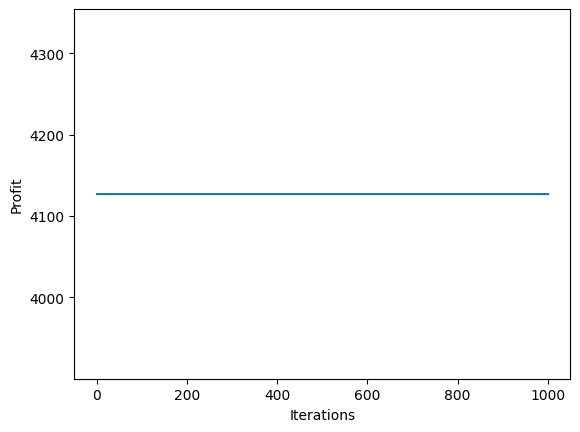

In [14]:
second_solver.visualize_graph()

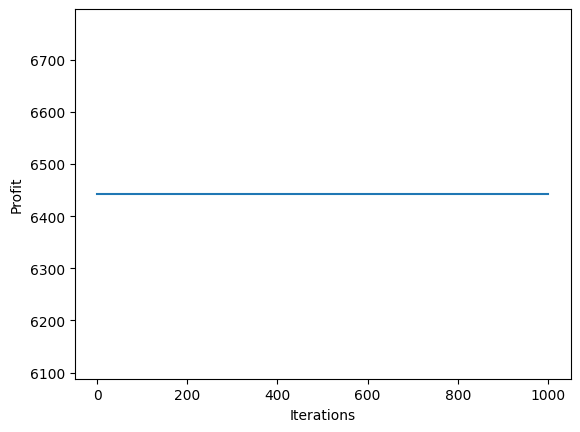

In [15]:
third_solver.visualize_graph()

In [16]:
first_map = first_solver.visualize_solution(prefix="A")
second_map = second_solver.visualize_solution(route_color="blue", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="green", m=second_map, prefix="C")
first_map

### Adaptive Genetic Algorithm with 3 Vehicles

#### Solution Class

In [17]:
class GACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_const,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_const = mutation_const
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)
   
    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        sig = 0.5 #initial mutation probability
        mutation_tracker = []
        max_mutation = 0
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            self.states.append(max(self.costs))
            mutation_tracker.extend(self.costs)
            if x % 10 == 0: #every 10th iteration adapts probability of adaptation based on # of successes in previous itetations
                z = len([1 for i in mutation_tracker if i >= max_mutation])
                if (z/len(mutation_tracker)*100) > 20:
                    sig = sig/self.mutation_const
                elif (z/len(mutation_tracker)*100) < 20:
                    sig = sig*self.mutation_const
                else: 
                    sig = sig
                max_mutation = max(mutation_tracker)
                mutation_tracker = []
                
            
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < sig:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        # print("States:", self.states)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Solution

In [18]:
from folium import Map, Marker, PolyLine, Icon
m = Map(location=pickup_nodes[0].coordinates[::-1], zoom_start=11)
bathurst_start = [43.82720773214452, -79.45379689449601]
bathurst_end = [43.636628218276, -79.3998242335392]
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
for x in pickup_nodes:
    if pickup_nodes.index(x) in second_vehicle_index:
        c  = "green"
    if pickup_nodes.index(x) in first_vehicle_index:
        c = "purple"
    if pickup_nodes.index(x) in third_vehicle_index:
        c = "red"
    Marker(location=x.coordinates[::-1], popup=x.coordinates, icon=Icon(color=c)).add_to(m)
PolyLine([bathurst_start, bathurst_end], color="red").add_to(m)
m


In [19]:
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
first_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in first_vehicle_index]
first_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in first_vehicle_index]
second_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in second_vehicle_index]
second_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in second_vehicle_index]
third_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in third_vehicle_index]
third_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in third_vehicle_index]


In [20]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_const = 0.85
crossover_prob = 0.7



In [21]:
first_solver = GACarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob)

# Initialize the population
first_solver.initial_population()
first_solver.run()

Initial Population costs:
[-2633.03, 2316.34, -1477.94, 2316.34, -2633.03, 2316.34, -1405.73, -2221.01, 829.93, 2494.18, 829.93, -2221.01, -2633.03, -530.36, -2221.01, -1430.42]
Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: 527 ID: 401220437]
Best Solution Profits: 3237.25


In [22]:
second_solver = GACarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0]],
    post_avoid = [first_solver.solution[-1]])

# Initialize the population
second_solver.initial_population()
second_solver.run()

Initial Population costs:
[1507.46, 3030.77, 1159.43, 3839.54, 4127.15, 3839.54, 3030.77, 1507.46, 1507.46, 3839.54, 1507.46, 2598.65, 1507.46, 4127.15, 3839.54, 3839.54]
Best Solution: [Name: 93 ID: 4035051033, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 75 ID: 31812627]
Best Solution Profits: 4127.15


In [23]:
third_solver = GACarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], second_solver.solution[0]],
    post_avoid = [first_solver.solution[-1], second_solver.solution[-1]])

# Initialize the population
third_solver.initial_population()
third_solver.run()

Initial Population costs:
[6442.67, 4405.88, 5088.95, 4405.88, 2417.66, 4724.06, 5088.95, 5088.95, 5088.95, 2417.66, 5533.52, 2417.66, 4405.88, 4405.88, 2417.66, 5088.95]
Best Solution: [Name: 39 ID: 4948854636, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: Loblaws ID: 31582988]
Best Solution Profits: 6442.67


In [24]:
print("Total profit: ",round(first_solver.solution_cost+second_solver.solution_cost+third_solver.solution_cost,2))

Total profit:  13807.07


In [25]:
first_map = first_solver.visualize_solution(prefix="A")
second_map = second_solver.visualize_solution(route_color="blue", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="green", m=second_map, prefix="C")
first_map

##### Visualization

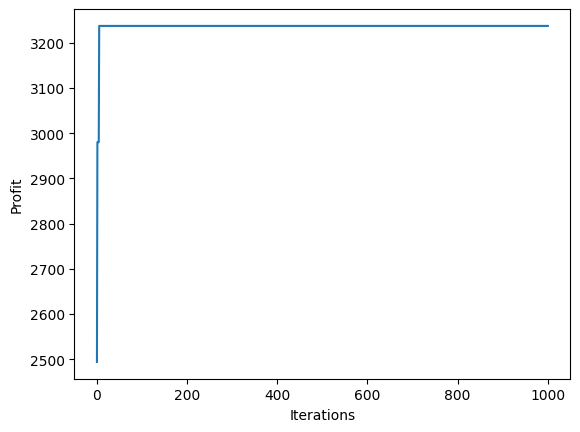

In [26]:
first_solver.visualize_graph()

In [27]:
first_solver.visualize_solution()

### Particle Swarm Optimization

#### Solution Class

In [39]:
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
import random

class PSOCarSharingSolver:
    def __init__(self, depot_nodes, pickup_nodes, dropoff_nodes, trip_matrix, 
                 num_particles, num_swarms, iterations, w, c1, c2, pre_avoid = [], post_avoid = []):
        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.iterations = iterations
        self.num_particles = num_particles
        self.num_swarms = num_swarms
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible
        
    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def argmax(self, lst):
        # Based on https://towardsdatascience.com/there-is-no-argmax-function-for-python-list-cd0659b05e49
        return max(zip(lst, range(len(lst))))[1]
    
    def add(self, position, velocity):
        # Swap position indices according to velocity pairs (Lecture 6, slide 108)
        
        #print("Add position:", position)
        #print("Add velocity:", velocity, "\n")
        
        if velocity == [[1, 1]]:
            return position

        for element in velocity:
            tmp = position[element[0]]
            position[element[0]] = position[element[1]]
            position[element[1]] = tmp
        
        return position
    
    def subtract(self, posA, posB):
        # Calculate a velocity by doing posA - posB (Lecture 6, slide 109)
        if len(posA) != len(posB):
            #print("\nSubtraction posA:", posA)
            #print("\nSubtraction posB:", posB)
            #print("\nSubtraction posA length:", len(posA))
            #print("\nSubtraction posB length:", len(posB))
            raise Exception("Positions need to be same length")
        
        if posA == posB:
            return [[1, 1]] #this velocity would not cause any changes, would mean swapping the first element with itself
        
        velocity = []
        for i in range(len(posA)):
            if posA[i] != posB[i]:
                for j in range(len(posB)):
                    if posB[j] == posA[i]:
                        velocity.append([i, j])
        
        #print("\nSubtraction posA:", posA)
        #print("\nSubtraction posB:", posB)
        #print("Subtraction result:", velocity, "\n")
        
        return velocity
    
    def multiply(self, c, velocity):
        # Multiply a velocity by a constant (Lecture 6, slide 110)
        
        #print("Mult c:", c)
        #print("Mult v:", velocity)
        
        if c == 0:
            return [[1, 1]]
        elif c > 0 and c < 1:
            #print("Result:", velocity[:round(c*len(velocity))], "\n")
            return velocity[:round(c*len(velocity))]
        elif c > 1:
            #print("Result:", velocity*(c // 1) + velocity[:round((c%1)*len(velocity))], "\n")
            return velocity*(int(c // 1)) + velocity[:round((c % 1)*len(velocity))]
        else:
            raise Exception("Constant is not valid value.")
        
    
    def initial_particles(self):
        self.particles = [self.random_solution() for _ in range(self.num_particles)]
        self.costs = self.fitness(self.particles)

    # Single vehicle PSO
    def run(self):
        # Check that initial particles exist:
        if self.particles:
            # Show some information
            print("Initial Particles costs:")
            print(self.costs, "\n")
        else:
            raise Exception("Particles not initialized.")
        
        #Initialize particle velocities to zero (single pair of same indices getting swapped)
        velocities = [[[1, 1]] for i in range(self.num_particles)]
       
        r1 = random.random()
        r2 = random.random()
        
        pps = self.num_particles // self.num_swarms # particles per swarm
        
        for iter_count in range(self.iterations):            
            #Updates for graphing iterations
            self.costs = self.fitness(self.particles)
            self.states.append(max(self.costs))
            
            # Segment particles into swarms
            swarms = []
            for i in range(self.num_swarms):
                swarms.append(self.particles[i * (pps): i*(pps) + pps])
            
            # Calculate best fitness for each particle, swarm, global for initial iteration
            if iter_count == 0:
                pBests_netProfit = self.fitness(self.particles)
                nBests_netProfit = [max(self.fitness(swarm)) for swarm in swarms]
                gBest_netProfit = max(nBests_netProfit)
                
                # Corresponding particle soultions
                pBests = [particle for particle in self.particles]
                nBests = [swarm[self.argmax(self.fitness(swarm))] for swarm in swarms]
                gBest = self.particles[self.argmax(self.fitness(self.particles))]
                
            #print("\npBests_netProfit:", pBests_netProfit)
            #print("nBests_netProfit:", nBests_netProfit)
            #print("gBest_netProfit:", gBest_netProfit)
            #print("nBests:", nBests)
            #print("gBest:", gBest)
            #print("\nVelocities:", velocities)
            #print("Swarms before update:", swarms)
            
            # Iterate over particles to update particle velocities and positions
            # Update nBest and gBest inside the loop (asynchronous method)
            particles = []
            for i, swarm in enumerate(swarms):
                for j, particle in enumerate(swarm):
                    # Remove start/end depot
                    particle = particle[1:-1]
                    #print("Particle before update (no depot):", particle)
                    inertial_velocity = self.multiply(self.w, velocities[j])
                    cognitive_velocity = self.multiply(self.c1*r1, self.subtract(pBests[j][1:-1], particle))
                    social_velocity = self.multiply(self.c2*r2, self.subtract(nBests[i][1:-1], particle))
                           
                    #print("Inertia:", inertial_velocity)
                    #print("Cognitive:", cognitive_velocity)
                    #print("Social:", social_velocity)
                    
                    # Update velocities
                    velocities[i*len(swarm) + j] = inertial_velocity + cognitive_velocity + social_velocity
                    #print("Total velocity", velocities[i*len(swarm) + j], "\n\n")
                    
                    # Update particle position
                    particle = self.add(particle, velocities[i*len(swarm) + j])
                    #print("Particle after update (no depot):", particle, "\n")
                    
                    # Add back closest start/end depot to the particle
                    particle = self.find_depots(particle)
                    
                    particles.append(particle)
                    
                    #print("After find_depots:", particle)
                    #print("Length:", len(particle), "\n")
                               
                    # Update pBest
                    if pBests_netProfit[i*len(swarm) + j] < self.fitness([particle]):
                        pBests[i*len(swarm) + j] = deepcopy(particle)
                        pBests_netProfit[i*len(swarm) + j] = self.fitness([particle])
                    
                    # Update nBest
                    if nBests_netProfit[i] < self.fitness([particle]):
                        nBests[i] = deepcopy(particle)
                        nBests_netProfit[i] = self.fitness([particle])
                        
                    # Update gBest
                    if gBest_netProfit < self.fitness([particle]):
                        #print("In gBest update. gBest_netProfit=", gBest_netProfit, "self.fitness([particle])=", self.fitness([particle]))
                        gBest = deepcopy(particle)
                        gBest_netProfit = self.fitness([particle])
                        #print("Updated gBest with net profit", gBest_netProfit, "\n")
            
            # Update self.particles to keep results of update steps
            self.particles = particles
                       
        # Update for end of last iteration
        self.costs = self.fitness(self.particles)
        self.states.append(max(self.costs))       
        
        # Show best solution
        self.solution = gBest #max(self.particles,key= lambda x: self.costs[self.particles.index(x)])
        self.solution_cost = gBest_netProfit #self.costs[self.particles.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("\nBest Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        
    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

For reference, run the PSO solver assuming a single vehicle will be completing all the pickups/dropoffs.

In [29]:
solver = PSOCarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w=0.8,
    c1=1.2,
    c2=1.5)

solver.initial_particles()
solver.run()

Initial Particles costs:
[5888.39, 6094.43, 5158.37, 6299.27, 1825.34, 8240.51, 5162.81, 6765.41, 2960.24, 7400.6, 9198.98, 7501.37, -2925.43, 5498.15, 2580.92, 1468.25, 321.92, 2251.64, 913.07, 9047.15] 


Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 93 ID: 4035051033]
Best Solution Profits: [18388.49]


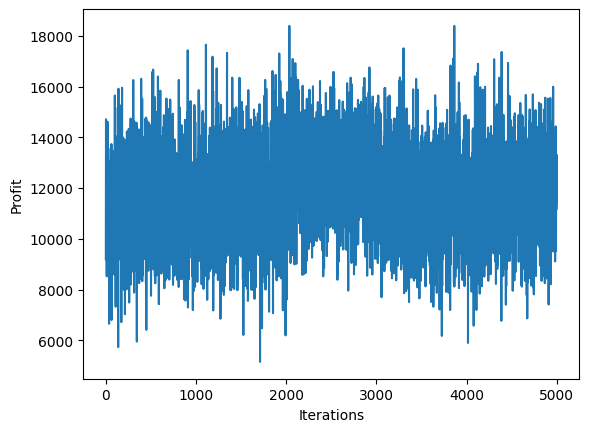

In [30]:
solver.visualize_graph()

In [31]:
solver.visualize_solution()

#### 3 Vehicle Solution

In [33]:
first_solver = PSOCarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w=0.8,
    c1=1.2,
    c2=1.5)

first_solver.initial_particles()
first_solver.run()

Initial Particles costs:
[-225.71, 166.15, -2633.03, -1477.94, -2633.03, 2501.26, 2494.18, -2221.01, -530.36, 1758.19, -2633.03, -2633.03, -530.36, -1430.42, 1758.19, 1758.19, -530.36, 1041.52, -2148.8, -225.71] 


Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: 527 ID: 401220437]
Best Solution Profits: [3237.25]


In [47]:
second_solver = PSOCarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w=0.8,
    c1=3,
    c2=1)

second_solver.initial_particles()
second_solver.run()

Initial Particles costs:
[4017.83, 4826.99, 4017.83, 3605.09, 4017.83, 4779.11, 4779.11, 4826.99, 4017.83, 3605.09, 4779.11, 4779.11, 4017.83, 3630.08, 3605.09, 4779.11, 4779.11, 4826.99, 4017.83, 4826.99] 


Best Solution: [Name: Loblaws ID: 31582988, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: Loblaws ID: 31582988]
Best Solution Profits: 4826.99


In [48]:
third_solver = PSOCarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w=0.8,
    c1=3,
    c2=1)

third_solver.initial_particles()
third_solver.run()

Initial Particles costs:
[6412.34, 3799.76, 6412.34, 6864.71, 6412.34, 6268.01, 6268.01, 3799.76, 6412.34, 6864.71, 6268.01, 6268.01, 6412.34, 4771.07, 6864.71, 6268.01, 6268.01, 3799.76, 6412.34, 3799.76] 


Best Solution: [Name: 93 ID: 4035051033, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 6864.71


In [50]:
print("Total profit:", first_solver.solution_cost + 
                             second_solver.solution_cost + 
                             third_solver.solution_cost)

Total profit: [14928.95]


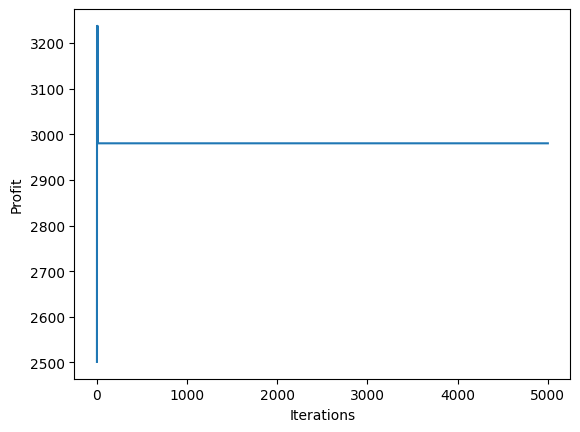

In [51]:
first_solver.visualize_graph()

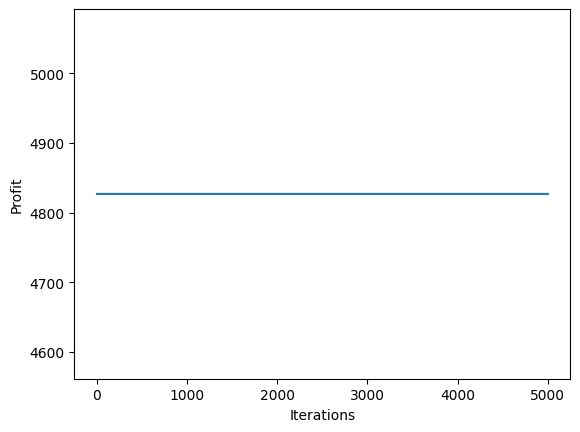

In [52]:
second_solver.visualize_graph()

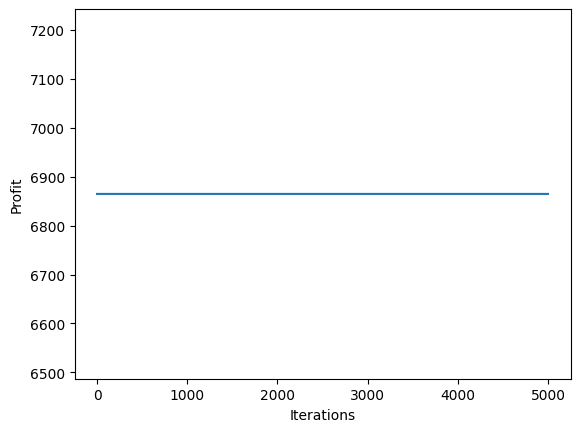

In [53]:
third_solver.visualize_graph()

In [55]:
first_map = first_solver.visualize_solution(route_color="red", prefix="A")
second_map = second_solver.visualize_solution(route_color="green", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="magenta", m=second_map, prefix="C")

first_map

# 3PSO

In [87]:
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
import random
import itertools
from itertools import islice
from random import randint

class PSOMultiCarSharingSolver:
    def __init__(self, depot_nodes, pickup_nodes, dropoff_nodes, trip_matrix, 
                 num_particles, num_swarms, num_vehicles, iterations, w, c1, c2, pre_avoid = [], post_avoid = []):
        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.iterations = iterations
        self.num_particles = num_particles # note this is the number of particles used per vehicle
        self.num_swarms = num_swarms
        self.num_vehicles = num_vehicles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible
        
    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self, pickups):
        route = []
        can_visit = deepcopy(pickups)
        for i in range(len(pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle in solutions:
            #print("Vehicle:", vehicle, "\n")
            for vehicle_route in vehicle:
                #print("Route:", vehicle_route, "\n")
                # We need to expand the routes into pickup-dropoffs to calculate actual cost
                expanded_route = self.expand_route(vehicle_route)
                total = 0
                for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                    if stop in self.pickups and next_stop in self.dropoffs:
                        cost_factor = 0.5
                    else:
                        cost_factor = -0.3
                    total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def argmax(self, lst):
        # Based on https://towardsdatascience.com/there-is-no-argmax-function-for-python-list-cd0659b05e49
        return max(zip(lst, range(len(lst))))[1]
    
    def partition_list(self, lst, num_partitions):
        k, m = divmod(len(lst), num_partitions)
        return [lst[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(num_partitions)]
    
    def add(self, position, velocity):
        # Swap position indices according to velocity pairs (Lecture 6, slide 108)
        
        #print("Add position:", position)
        #print("Add velocity:", velocity, "\n")
        
        # Unpartition the list
        #position = list(itertools.chain.from_iterable(position))
        
        if velocity == [[1, 1]]:
            #position = self.partition_list(position, self.num_vehicles) # repartition
            return position

        for element in velocity:
            tmp = position[element[0]]
            position[element[0]] = position[element[1]]
            position[element[1]] = tmp
        
        #position = self.partition_list(position, self.num_vehicles) # repartition
        return position
    
    def subtract(self, posA, posB):
        # Calculate a velocity by doing posA - posB (Lecture 6, slide 109)
        
        # Unpartition the list
        #posA = list(itertools.chain.from_iterable(posA))
        #posB = list(itertools.chain.from_iterable(posB))
        
        if len(posA) != len(posB):
            print("\nSubtraction posA:", posA)
            print("\nSubtraction posB:", posB)
            print("\nSubtraction posA length:", len(posA))
            print("\nSubtraction posB length:", len(posB))
            raise Exception("Positions need to be same length")
        
        if posA == posB:
            return [[1, 1]] #this velocity would not cause any changes, would mean swapping the first element with itself
        
        velocity = []
        for i in range(len(posA)):
            if posA[i] != posB[i]:
                for j in range(len(posB)):
                    if posB[j] == posA[i]:
                        velocity.append([i, j])
        
        #print("\nSubtraction posA:", posA)
        #print("\nSubtraction posB:", posB)
        #print("Subtraction result:", velocity, "\n")
        
        return velocity
    
    def multiply(self, c, velocity):
        # Multiply a velocity by a constant (Lecture 6, slide 110)
        
        #print("Mult c:", c)
        #print("Mult v:", velocity)
        
        if c == 0:
            return [[1, 1]]
        elif c > 0 and c < 1:
            #print("Result:", velocity[:round(c*len(velocity))], "\n")
            return velocity[:round(c*len(velocity))]
        elif c > 1:
            #print("Result:", velocity*(c // 1) + velocity[:round((c%1)*len(velocity))], "\n")
            return velocity*(int(c // 1)) + velocity[:round((c % 1)*len(velocity))]
        else:
            raise Exception("Constant is not valid value.")       
    
    def initial_particles(self):
        # Partition the pickups into list of lists (one list per vehicle) 
        pickups = self.partition_list(self.pickups, self.num_vehicles)
        
        # Create a set of particles for each vehicle
        particles = []
        for i in range(self.num_particles):
            particle = []
            for j in range(self.num_vehicles):
                particle.append(self.random_solution(pickups[j]))
            print("Particle", i, particle, "\n")
            particles.append(deepcopy(particle))
        
        #for i in range(self.num_vehicles):
        #    print(pickups[i], "\n")
        #    particles.append([self.random_solution(pickups[i]) for _ in range(self.num_particles)])
        
        self.particles = particles
        #print("Initial particles", self.particles, "\n")
        #print("Costs: \n")
        self.costs = self.fitness(self.particles)

    # Single vehicle PSO
    def run(self):
        # Check that initial particles exist:
        if self.particles:
            # Show some information
            print("Initial Particles costs:")
            print(self.costs, "\n")
        else:
            raise Exception("Particles not initialized.")
        
        #Initialize particle velocities to zero (single pair of same indices getting swapped)
        velocities = [[[1, 1]] for i in range(self.num_particles)]
       
        r1 = random.random()
        r2 = random.random()
        
        pps = self.num_particles // self.num_swarms # particles per swarm
        
        for iter_count in range(self.iterations):            
            #Updates for graphing iterations
            self.costs = self.fitness(self.particles)
            self.states.append(max(self.costs))
            
            # Segment particles into swarms
            swarms = []
            for i in range(self.num_swarms):
                swarms.append(self.particles[i * (pps): i*(pps) + pps])
            
            # Calculate best fitness for each particle, swarm, global for initial iteration
            if iter_count == 0:
                pBests_netProfit = self.fitness(self.particles)
                nBests_netProfit = [max(self.fitness(swarm)) for swarm in swarms]
                gBest_netProfit = max(nBests_netProfit)
                
                # Corresponding particle soultions
                pBests = [particle for particle in self.particles] #unpartitioned
                print("pBests", pBests, "\n")
                nBests = [swarm[self.argmax(self.fitness(swarm))] for swarm in swarms]
                gBest = self.particles[self.argmax(self.fitness(self.particles))]
                
            #print("\npBests_netProfit:", pBests_netProfit)
            #print("nBests_netProfit:", nBests_netProfit)
            #print("gBest_netProfit:", gBest_netProfit)
            #print("nBests:", nBests)
            #print("gBest:", gBest)
            #print("\nVelocities:", velocities)
            #print("Swarms before update:", swarms)
            
            # Iterate over particles to update particle velocities and positions
            # Update nBest and gBest inside the loop (asynchronous method)
            particles = []
            for i, swarm in enumerate(swarms):
                for j, particle in enumerate(swarm):
                    
                    # Remove start/end point
                    for v_route in particle:
                        v_route = v_route[1:-1]
                    
                    #Unpartition
                    particle = list(itertools.chain.from_iterable(particle))
                    
                    #list(itertools.chain.from_iterable(pBests[j][1:-1]))
                    
                    # Remove start/end depot
                    #particle = particle[1:-1]
                    
                    inertial_velocity = self.multiply(self.w, velocities[j])
                    cognitive_velocity = self.multiply(self.c1*r1, self.subtract(list(itertools.chain.from_iterable(pBests[j][:][1:-1])), particle))
                    social_velocity = self.multiply(self.c2*r2, self.subtract(list(itertools.chain.from_iterable(nBests[i][:][1:-1])), particle))
                           
                    #print("Inertia:", inertial_velocity)
                    #print("Cognitive:", cognitive_velocity)
                    #print("Social:", social_velocity)
                    
                    # Update velocities
                    velocities[i*len(swarm) + j] = inertial_velocity + cognitive_velocity + social_velocity
                    #print("Total velocity", velocities[i*len(swarm) + j], "\n\n")
                    
                    # Update particle position
                    particle = self.add(particle, velocities[i*len(swarm) + j])
                    #print("Particle after update (no depot):", particle, "\n")
                    
                    #Repartition
                    particle = partition_list(particle, self.num_vehicles)
                    
                    # Add back closest start/end depot to the vehicles in the particle
                    for partition in particle:
                        partition = [self.find_depots(vehicle_route) for vehicle_route in partition]
                                        
                    particles.append(particle)
                    
                    #print("After find_depots:", particle)
                    #print("Length:", len(particle), "\n")
                               
                    # Update pBest
                    if pBests_netProfit[i*len(swarm) + j] < self.fitness([particle]):
                        pBests[i*len(swarm) + j] = deepcopy(particle)
                        pBests_netProfit[i*len(swarm) + j] = self.fitness([particle])
                    
                    # Update nBest
                    if nBests_netProfit[i] < self.fitness([particle]):
                        nBests[i] = deepcopy(particle)
                        nBests_netProfit[i] = self.fitness([particle])
                        
                    # Update gBest
                    if gBest_netProfit < self.fitness([particle]):
                        #print("In gBest update. gBest_netProfit=", gBest_netProfit, "self.fitness([particle])=", self.fitness([particle]))
                        gBest = deepcopy(particle)
                        gBest_netProfit = self.fitness([particle])
                        #print("Updated gBest with net profit", gBest_netProfit, "\n")
                    
                    
                    
                    
                    
            
            # Update self.particles to keep results of update steps
            self.particles = particles
                       
        # Update for end of last iteration
        self.costs = self.fitness(self.particles)
        self.states.append(max(self.costs))       
        
        # Show best solution
        self.solution = gBest #max(self.particles,key= lambda x: self.costs[self.particles.index(x)])
        self.solution_cost = gBest_netProfit #self.costs[self.particles.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("\nBest Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        
    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

In [88]:
solver = PSOMultiCarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix,
    num_particles=20,
    num_swarms=5,
    num_vehicles = 3,
    iterations=5000,
    w=0.8,
    c1=1.2,
    c2=1.5)

solver.initial_particles()
solver.run()

Particle 0 [[Name: Loblaws ID: 31582988, Name: Bayview Avenue ID: 2525612330, Name: 90 ID: 804610960, Name: 444 ID: 4035049080, Name: 565 ID: 803149738, Name: 527 ID: 401220437], [Name: 93 ID: 4035051033, Name: Toronto Transit Commission ID: 32052212, Name: 799 ID: 401062600, Name: St. Barnabas Anglican Church ID: 43811604, Name: Loblaws ID: 31582988], [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: The Squire and Firkin ID: 2287594369, Name: October Convenience ID: 588647080, Name: 75 ID: 31812627]] 

Particle 1 [[Name: 93 ID: 4035051033, Name: 565 ID: 803149738, Name: Bayview Avenue ID: 2525612330, Name: 444 ID: 4035049080, Name: 90 ID: 804610960, Name: Loblaws ID: 31582988], [Name: 93 ID: 4035051033, Name: 799 ID: 401062600, Name: Toronto Transit Commission ID: 32052212, Name: St. Barnabas Anglican Church ID: 43811604, Name: Loblaws ID: 31582988], [Name: 75 ID: 31812627, Name: The Squire and Firkin ID: 2287594369, Name: October Convenience ID: 588647080, Name: 

Exception: Positions need to be same length

### Adaptive Particle Swarm Optimization with 3 Vehicles

### Comparison of Algorithms

Conduct a comparative analysis on genetic algorithm, adaptive genetic algorithm, swarm intelligence algorithm and adaptive swarm intelligence algorithm in terms of the generated profit, CPU times and Wall time spent in getting the solutions.